In [1]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Total 14652 (delta 0), reused 0 (delta 0), pack-reused 14652 (from 1)
Receiving objects: 100% (14652/14652), 25.54 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (9793/9793), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.2 MB/s eta 0:00:00
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 123622 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:am

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
with torch.inference_mode():
    positive_prompt = "a greek philosopher, sitting on the ground on the edge of the acropolis, playing a game on a macbook pro"
    negative_prompt = "deformed finger, ugliness, sadness, artifact, poor quality, defect, nsfw, facial deformity, deformed hand, deformation, deformities, malformations, sexuality, sex"
    width = 2000
    height = 1060
    seed = 0
    steps = 95
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    decoded = process_and_save_image(sample, vae)
if decoded is not None:
    display(Image.fromarray(decoded))
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

3582432914070383749


  0%|          | 0/95 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 99.06 MiB is free. Process 10068 has 14.65 GiB memory in use. Of the allocated memory 14.39 GiB is allocated by PyTorch, and 138.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [92]:
import torch
import torch.nn.functional as F
import numpy as np
import math

def decode_with_memory_management(sample, vae, tile_size=32, overlap=8, target_width=2000, target_height=1060):
    """
    Decode VAE output using memory-saving techniques with seamless tile blending.
    """
    if isinstance(sample, dict):
        image_tensor = sample['samples']
    else:
        image_tensor = sample

    # Get dimensions and pad to multiples of 8
    batch_size, channels, height, width = image_tensor.shape
    padded_width = math.ceil(width / 8) * 8
    padded_height = math.ceil(height / 8) * 8

    # Calculate output dimensions (VAE upscales by 8)
    out_width = padded_width * 8
    out_height = padded_height * 8

    # Initialize the final numpy array and weight accumulator
    decoded_numpy = np.zeros((3, out_height, out_width), dtype=np.float32)
    weight_acc = np.zeros((out_height, out_width), dtype=np.float32)

    # Calculate effective stride (tile_size - overlap)
    stride = tile_size - overlap

    # Calculate number of tiles
    num_tiles_h = math.ceil((height - overlap) / stride)
    num_tiles_w = math.ceil((width - overlap) / stride)

    def create_gaussian_weight(size):
        # Creates a Gaussian weight matrix for blending
        x = np.linspace(-1, 1, size)
        y = np.linspace(-1, 1, size)
        xv, yv = np.meshgrid(x, y)
        gaussian = np.exp(-((xv**2 + yv**2) / 0.5**2))
        return gaussian.astype(np.float32)

    try:
        for h in range(num_tiles_h):
            for w in range(num_tiles_w):
                # Calculate tile boundaries with overlap
                h_start = h * stride
                w_start = w * stride
                h_end = min(h_start + tile_size, height)
                w_end = min(w_start + tile_size, width)

                # Determine padding size, ensuring it doesn’t exceed the available dimensions
                pad_right = max(0, min(tile_size - (w_end - w_start), width - w_start - (w_end - w_start)))
                pad_bottom = max(0, min(tile_size - (h_end - h_start), height - h_start - (h_end - h_start)))

                with torch.no_grad():
                    # Extract tile and only pad if within acceptable limits
                    tile = image_tensor[:, :, h_start:h_end, w_start:w_end].clone()
                    if pad_right > 0 or pad_bottom > 0:
                        if tile.shape[3] + pad_right <= tile_size and tile.shape[2] + pad_bottom <= tile_size:
                            tile = F.pad(tile, (0, pad_right, 0, pad_bottom), mode='reflect')
                        else:
                            print("Skipping padding due to size limits at boundaries")

                    # Decode the tile
                    decoded_tile = vae.decode(tile)
                    tile_np = decoded_tile.cpu().numpy()

                    # Ensure tile_np dimensions match expectations
                    if tile_np.shape[-1] == 3:
                        tile_np = np.transpose(tile_np, (0, 3, 1, 2))
                    if tile_np.ndim == 4:
                        tile_np = tile_np[0]

                    # Calculate output positions
                    out_h_start = h_start * 8
                    out_w_start = w_start * 8
                    out_h_end = min(out_h_start + tile_np.shape[1], out_height)
                    out_w_end = min(out_w_start + tile_np.shape[2], out_width)

                    # Adjust weight section dimensions to match tile dimensions
                    tile_height = out_h_end - out_h_start
                    tile_width = out_w_end - out_w_start
                    weight_section = create_gaussian_weight(tile_size * 8)[:tile_height, :tile_width]

                    # Verify that tile_np and weight_section have matching dimensions
                    if tile_np.shape[1:3] != weight_section.shape:
                        tile_np = tile_np[:, :tile_height, :tile_width]

                    # Apply weighted accumulation
                    for c in range(3):
                        decoded_numpy[c, out_h_start:out_h_end, out_w_start:out_w_end] += \
                            tile_np[c, :tile_height, :tile_width] * weight_section
                    weight_acc[out_h_start:out_h_end, out_w_start:out_w_end] += weight_section

                torch.cuda.empty_cache()  # Free GPU memory

    except Exception as e:
        print(f"Error during tiled processing: {e}")
        return None

    # Normalize by accumulated weights
    mask = weight_acc > 0
    for c in range(3):
        decoded_numpy[c, mask] /= weight_acc[mask]

    # Convert to uint8
    decoded_numpy = (decoded_numpy * 255).clip(0, 255).astype(np.uint8)

    # Crop to target size
    decoded_numpy = decoded_numpy[:, :target_height*8, :target_width*8]

    return decoded_numpy

In [93]:
with torch.no_grad():
    result = process_and_save_image_managed(
        sample, vae,
        target_width=2000,
        target_height=1060
    )
    if result is not None:
        print("Image successfully processed and saved")

Image saved with dimensions: 2048x1088
Image successfully processed and saved


Notez que le code python suivant fonctionne aussi mais
(i) il trouve le nbre entier multiple de 8 le plus proche de la taille de la longueur, et même chose pour la largeur.
(ii) en output on voit clairement le pavage des différentes *tiles*

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import gc
import math

def force_memory_clear():
    """Aggressive memory clearing"""
    gc.collect()
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def decode_with_memory_management(sample, vae, tile_size=16):
    """
    Decode VAE output using extreme memory saving techniques
    with corrected dimension handling
    """
    if isinstance(sample, dict):
        image_tensor = sample['samples']
    else:
        image_tensor = sample

    # Get dimensions
    batch_size, channels, height, width = image_tensor.shape

    # Calculate output dimensions (VAE upscales by 8)
    out_height = height * 8
    out_width = width * 8

    # Initialize the final numpy array instead of tensor
    decoded_numpy = np.zeros((3, out_height, out_width), dtype=np.uint8)

    # Calculate number of tiles
    num_tiles_h = math.ceil(height / tile_size)
    num_tiles_w = math.ceil(width / tile_size)

    try:
        for h in range(num_tiles_h):
            for w in range(num_tiles_w):
                # Calculate tile boundaries
                h_start = h * tile_size
                w_start = w * tile_size
                h_end = min(h_start + tile_size, height)
                w_end = min(w_start + tile_size, width)

                # Process each tile
                with torch.no_grad():
                    # Extract tile
                    tile = image_tensor[:, :, h_start:h_end, w_start:w_end].clone()

                    try:
                        # Decode tile
                        decoded_tile = vae.decode(tile)

                        # Convert to numpy and handle dimensions
                        if isinstance(decoded_tile, torch.Tensor):
                            tile_np = decoded_tile.cpu().numpy()
                        else:
                            tile_np = np.array(decoded_tile)

                        # Ensure correct shape and transpose if needed
                        if tile_np.shape[-1] == 3:  # If channels are last
                            tile_np = np.transpose(tile_np, (0, 3, 1, 2))

                        # Remove batch dimension if present
                        if tile_np.ndim == 4:
                            tile_np = tile_np[0]

                        # Scale to 0-255 range
                        tile_np = (tile_np * 255).clip(0, 255).astype(np.uint8)

                        # Calculate output positions
                        out_h_start = h_start * 8
                        out_w_start = w_start * 8
                        out_h_end = h_end * 8
                        out_w_end = w_end * 8

                        # Store result
                        decoded_numpy[:, out_h_start:out_h_end,
                                    out_w_start:out_w_end] = tile_np

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print(f"OOM with tile size {tile_size}, processing in quarters...")
                            # Process tile in quarters
                            mid_h = (h_end - h_start) // 2
                            mid_w = (w_end - w_start) // 2

                            quarters = [
                                (h_start, h_start + mid_h, w_start, w_start + mid_w),
                                (h_start + mid_h, h_end, w_start, w_start + mid_w),
                                (h_start, h_start + mid_h, w_start + mid_w, w_end),
                                (h_start + mid_h, h_end, w_start + mid_w, w_end)
                            ]

                            for hs, he, ws, we in quarters:
                                with torch.no_grad():
                                    quarter_tile = image_tensor[:, :, hs:he, ws:we].clone()
                                    decoded_quarter = vae.decode(quarter_tile)

                                    # Convert quarter to numpy and handle dimensions
                                    if isinstance(decoded_quarter, torch.Tensor):
                                        quarter_np = decoded_quarter.cpu().numpy()
                                    else:
                                        quarter_np = np.array(decoded_quarter)

                                    if quarter_np.shape[-1] == 3:
                                        quarter_np = np.transpose(quarter_np, (0, 3, 1, 2))

                                    if quarter_np.ndim == 4:
                                        quarter_np = quarter_np[0]

                                    quarter_np = (quarter_np * 255).clip(0, 255).astype(np.uint8)

                                    # Store quarter result
                                    decoded_numpy[:, hs*8:he*8, ws*8:we*8] = quarter_np

                                force_memory_clear()
                        else:
                            raise e

                # Clear memory after each tile
                force_memory_clear()

    except Exception as e:
        print(f"Error during tiled processing: {e}")
        print(f"Error details: {str(e)}")
        return None

    return decoded_numpy

def process_and_save_image_managed(sample, vae, output_path="/content/flux.png"):
    """
    Process and save image using memory management
    """
    try:
        # Ensure we start with clean memory
        force_memory_clear()

        decoded_numpy = decode_with_memory_management(sample, vae)
        if decoded_numpy is not None:
            # Transpose for PIL image format
            final_image = np.transpose(decoded_numpy, (1, 2, 0))
            Image.fromarray(final_image).save(output_path)
            return final_image
        return None

    except Exception as e:
        print(f"Error during processing: {e}")
        print(f"Error details: {str(e)}")
        return None

In [ ]:
with torch.no_grad():
    result = process_and_save_image_managed(sample, vae)
    if result is not None:
        print("Image successfully processed and saved")

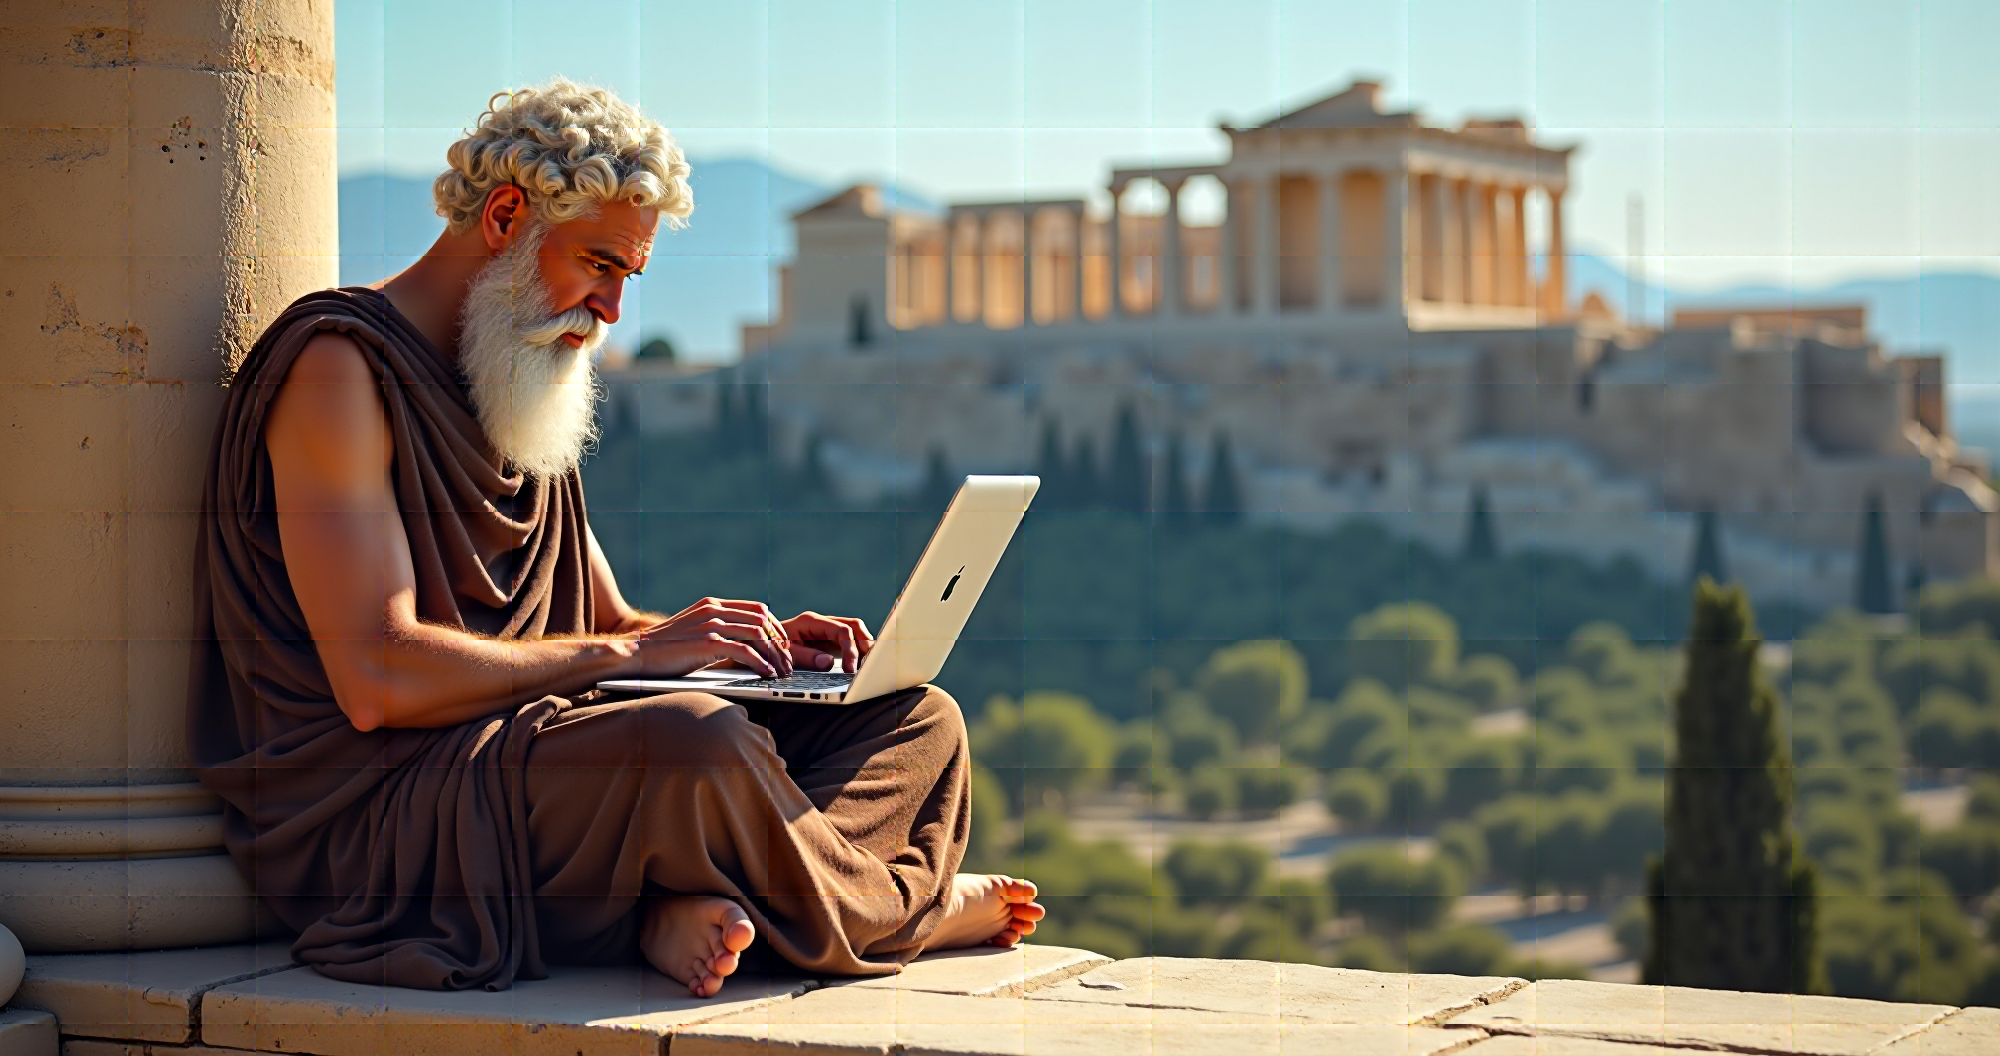